# VAE training

In [ ]:
# !pip install lightning

In [2]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import tables
import h5py


from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.lines import Line2D

from sklearn.metrics import f1_score

print(torch.cuda.device_count())

np.random.seed(seed=1)
L.seed_everything(seed=1, workers=True)

Seed set to 1


1


1

In [3]:
os.getcwd()

'/eos/home-i03/e/epivacal/VAE_anomalyHEP/notebooks'

In [4]:
folder_path = '../data'
h5_files = [f for f in os.listdir(folder_path) if f.endswith('2.h5')]
print(h5_files)

['ntuple_merged_12.h5', 'ntuple_merged_2.h5']


In [162]:
import h5py

# List to store sets of keys per file
key_sets = []

for file_name in h5_files:
    file_path = os.path.join(folder_path, file_name)
    with h5py.File(file_path, "r") as f:
        keys = set(f.keys())  # Get the set of top-level keys
        key_sets.append(keys)

# Compute intersection of all key sets
if key_sets:
    common_keys = set.intersection(*key_sets)

    if common_keys:
        # Use the first file to get shape and dtype
        first_file_path = os.path.join(folder_path, h5_files[0])
        with h5py.File(first_file_path, "r") as f:
            #print("Common variables with shape and dtype (from first file):")
            for key in sorted(common_keys):
                if isinstance(f[key], h5py.Dataset):
                    shape = f[key].shape
                    dtype = f[key].dtype
                    print(f"Dataset: {key}, Shape: {f[key].shape}, Type: {f[key].dtype}")
                else:
                    print(f"{key} is not a dataset.")
    else:
        print("No common variables found across all files.")
else:
    print("No .h5 files found in the folder.")

Dataset: A_Dr_Z, Shape: (50000,), Type: float32
Dataset: A_Lep1Z_eta, Shape: (50000,), Type: float32
Dataset: A_Lep1Z_phi, Shape: (50000,), Type: float32
Dataset: A_Lep1Z_pt, Shape: (50000,), Type: float32
Dataset: A_Lep2Z_eta, Shape: (50000,), Type: float32
Dataset: A_Lep2Z_phi, Shape: (50000,), Type: float32
Dataset: A_Lep2Z_pt, Shape: (50000,), Type: float32
Dataset: A_Lep3W_eta, Shape: (50000,), Type: float32
Dataset: A_Lep3W_phi, Shape: (50000,), Type: float32
Dataset: A_Lep3W_pt, Shape: (50000,), Type: float32
Dataset: A_Sum_mass, Shape: (50000,), Type: float32
Dataset: A_Sum_pt, Shape: (50000,), Type: float32
Dataset: A_Wmass, Shape: (50000,), Type: float32
Dataset: A_Zmass, Shape: (50000,), Type: float32
Dataset: A_nlep, Shape: (50000,), Type: float32
Dataset: A_ptZ, Shape: (50000,), Type: float32
Dataset: B_Dr_Z, Shape: (50000,), Type: float32
Dataset: B_Lep1Z_eta, Shape: (50000,), Type: float32
Dataset: B_Lep1Z_phi, Shape: (50000,), Type: float32
Dataset: B_Lep1Z_pt, Shape: (

## Define the list of variables from the h5 file to use as features, spectator and labels

In [163]:
features = ['D_Dr_Z',
            'D_Lep1Z_pt',
            'D_Lep2Z_pt',
            'D_Lep1Z_eta',
            'D_Lep2Z_eta',
            'D_Lep1Z_phi',
            'D_Lep2Z_phi',
            'D_Lep3W_pt',
            'D_Lep3W_eta',
            'D_Lep3W_phi',
            'D_Sum_mass',
            'D_Sum_pt',
            'D_Wmass',
            'D_Zmass',
            'D_nlep',
            'MET_pt',
            'MET_phi',
            'D_ptZ',
            'D_mu1ip3d',
            'D_mu2ip3d',
            'D_mu3ip3d'
           ]

# spectators to define mass/pT window
# spectators = ['fj_sdmass',
#               'fj_pt']

# 2 labels: QCD or Hbb
labels = ['Dataset_ID']

nfeatures = len(features)
# nspectators = len(spectators)
nlabels = len(labels)

In [164]:
len(features)

21

In [165]:
def get_all_features_labels(folder_path):
    feature_list = []
    dataset_id_list = []
    label_list = []

    h5_files = [f for f in os.listdir(folder_path) if f.endswith('2.h5')]

    for file_name in h5_files:
        file_path = os.path.join(folder_path, file_name)
        with tables.open_file(file_path, 'r') as h5file:
            nevents = getattr(h5file.root, features[0]).shape[0]

            feature_array = np.zeros((nevents, nfeatures))
            label_array = np.zeros((nevents, 2))

            # Load features
            for i, feat in enumerate(features):
                feature_array[:, i] = getattr(h5file.root, feat)[:]

            # Load labels
            for i, label in enumerate(labels):
                dataset_id_array = getattr(h5file.root, label)[:]  # Load Dataset_ID
                label_array[:, 0] = np.isin(dataset_id_array, [1]).astype(int)  # Background
                label_array[:, 1] = np.isin(dataset_id_array, [3]).astype(int)  # Signal

        feature_list.append(feature_array)
        dataset_id_list.append(dataset_id_array)
        label_list.append(label_array)

    # Concatenate all arrays
    all_features = np.vstack(feature_list)
    all_dataset_ids = np.concatenate(dataset_id_list)
    all_labels = np.vstack(label_list)

    return all_features, all_dataset_ids, all_labels

In [166]:
# load training file
feature_array, dataset_id_array, label_array = get_all_features_labels(folder_path)

print(feature_array.shape)
print(dataset_id_array.shape)
print(label_array.shape)

(100000, 21)
(100000,)
(100000, 2)


In [167]:
# Get background and signal indices
background_indices = np.where(dataset_id_array == 1)[0]
signal_indices = np.where(dataset_id_array == 3)[0]

# Count background events
background_count = len(background_indices)

# Calculate number of signal events for a 1:1000 ratio
target_signal_count = max(1, background_count // 1000)  # Ensure at least 1 event

print(f"Background count: {background_count}")
print(f"Target signal count (1:100): {target_signal_count}")

# Downsample signal events
np.random.seed(1)
selected_signal_indices = np.random.choice(signal_indices, size=target_signal_count, replace=True)

# Combine indices
final_indices = np.concatenate([background_indices, selected_signal_indices])
np.random.shuffle(final_indices)

# Filter arrays
feature_array = feature_array[final_indices]
label_array = label_array[final_indices]
dataset_id_array = dataset_id_array[final_indices]

print("New shapes after downsampling:")
print("Features:", feature_array.shape)
print("Labels:", label_array.shape)
print("Dataset IDs:", dataset_id_array.shape)


Background count: 95041
Target signal count (1:100): 95
New shapes after downsampling:
Features: (95136, 21)
Labels: (95136, 2)
Dataset IDs: (95136,)


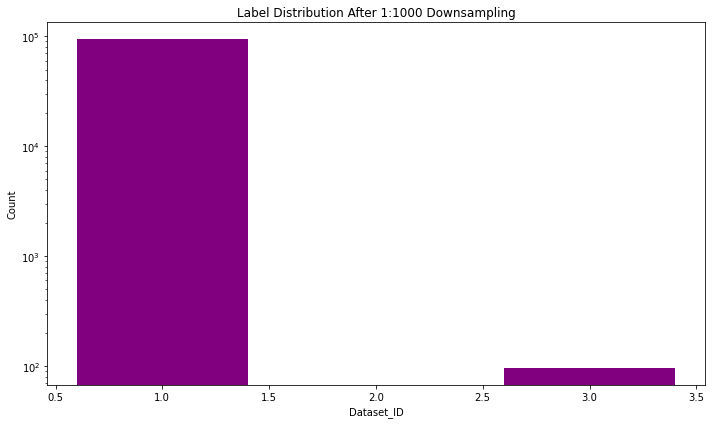

In [168]:
unique_labels, counts = np.unique(dataset_id_array, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='purple')
plt.yscale('log')
plt.xlabel('Dataset_ID')
plt.ylabel('Count')
plt.title('Label Distribution After 1:1000 Downsampling')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [169]:
feature_array[0]
feature_array[0].size

21

In [170]:
np.unique(dataset_id_array)

array([1., 3.], dtype=float32)

[1. 3.]
[95041    95]


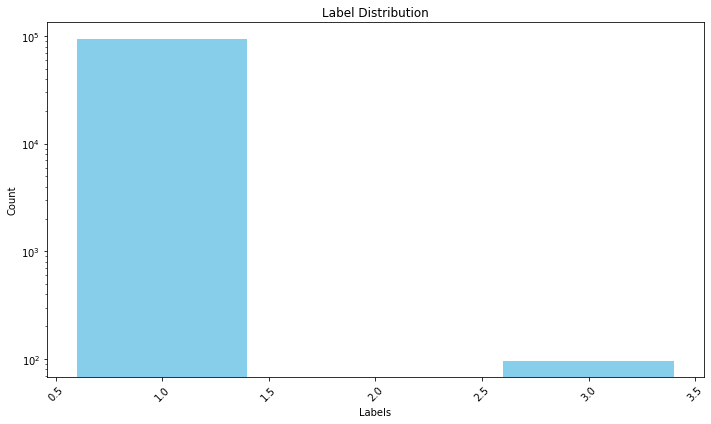

In [171]:
unique_labels, counts = np.unique(dataset_id_array, return_counts=True)
print(unique_labels)
print(counts)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.yscale('log')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [172]:
# Mapping the labels to 0-1
dataset_id_array

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [173]:
label_array

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [174]:
binary_labels = np.where(dataset_id_array <= 2, 0, 1)

In [175]:
# Divide train and validation+test
X_train, X_test, y_train, y_test= train_test_split(feature_array, binary_labels, test_size=0.2, random_state=42, shuffle=True, stratify = binary_labels)

# Divide validation+test in validation and test
#X_valid, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

### Load the data (numpy.array) into a DatasetLoad (Tensor)

In [176]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

## β-Variational Autoencoder
#### VAE: Pytorch Lightning Model Implementation
Weight for the Kullback–Leibler divergence of 0.5

In [177]:
class VariationalAutoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )
        
        self.fc_mu = nn.Linear(8, 8)
        self.fc_var = nn.Linear(8, 8)

        self.reconstruction_losses = []
        self.kl_losses = []
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

    def decode(self, z):
        result = self.decoder(z)
        return result

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparam(mu, log_var)
        return self.decode(z), input, mu, log_var

    def training_step(self, batch, batch_idx):
        input = batch
        output, _, mu, log_var = self.forward(input)
        loss = self.loss_fn(output, input, mu, log_var)
        
        # Log pérdidas para el logger (útil si usas CSVLogger)
        self.log('train_loss', loss['loss'], prog_bar=True)
        self.log('train_recon_loss', loss['rec'])
        self.log('train_kl_loss', loss['kld'])
        
        return loss['loss']

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())
        self.reconstruction_losses.append(self.trainer.callback_metrics['train_recon_loss'].item())
        self.kl_losses.append(self.trainer.callback_metrics['train_kl_loss'].item())
        

    def validation_step(self, batch, batch_idx):

        input = batch
        output, _, mu, log_var = self.forward(input)
        loss = self.loss_fn(output, input, mu, log_var)
        self.log('val_loss', loss['loss'], prog_bar=True)
        self.log('val_recon_loss', loss['rec'])
        self.log('val_kl_loss', loss['kld'])
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        return self.forward(input)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def loss_fn(self, *args, **kwargs) -> dict:

        recon = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = 0.5

        recon_loss = F.mse_loss(recon, input)
        kldiv_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recon_loss + kld_weight * kldiv_loss

        return {'loss': loss, 'rec': recon_loss.detach(), 'kld':-kldiv_loss.detach()}

In [178]:
# Progress bar

class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

### VAE Model Training

In [179]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

train = scaler.fit_transform(X_train)
test = scaler.transform(X_test)

vae_test_ds = SensorDataset(X_test)

In [180]:
# vae_train_ds = SensorDataset(X_train)
# vae_test_ds = SensorDataset(X_test)

In [181]:
model = VariationalAutoencoder(in_dim=train.shape[1])
batch_size = 32  # increase if GPU allows

vae_train, vae_valid = train_test_split(train, test_size = 0.15, random_state=1, shuffle=True)
vae_train_ds, vae_val_ds = SensorDataset(vae_train), SensorDataset(vae_valid)
vae_tdl, vae_vdl = DataLoader(vae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(vae_val_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()

trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=50, logger=False, enable_checkpointing=True, accelerator="auto")
#trainer.fit(model, train_dataloaders=ae_tdl)
trainer.fit(model, train_dataloaders=vae_tdl, val_dataloaders=vae_vdl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/eos/user/e/epivacal/.local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /eos/home-i03/e/epivacal/VAE-JULIO25/VAE_training/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 1.5 K  | train
1 | fc_mu   | Linear     | 72     | train
2 | fc_var  | Linear     | 72     | train
3 | decoder | Sequential | 1.5 K  | train
-----------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
Epoch 31: 100%|██████████| 2022/2022 [00:23<00:00, 87.46it/s, loss=0.9992, val_loss=1.0058]


### Loss Curve

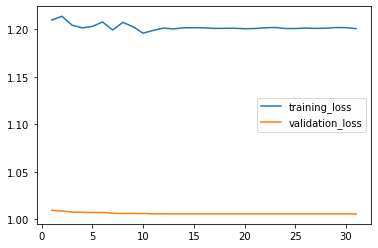

In [182]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

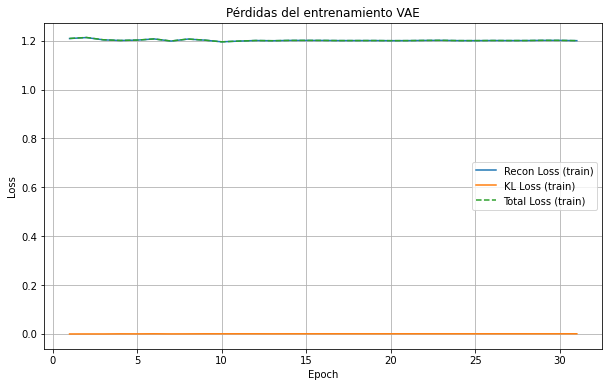

In [183]:
epochs = range(1, len(model.training_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, model.reconstruction_losses, label='Recon Loss (train)')
plt.plot(epochs, model.kl_losses, label='KL Loss (train)')
plt.plot(epochs, model.training_losses, label='Total Loss (train)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdidas del entrenamiento VAE')
plt.legend()
plt.grid(True)
plt.show()

##### Best Model Retrieval (EarlyStopping)

In [186]:
print(cp.best_model_path)
print(cp.best_model_score)
model = VariationalAutoencoder.load_from_checkpoint(cp.best_model_path)

/eos/home-i03/e/epivacal/VAE-JULIO25/VAE_training/checkpoints/epoch=23-step=48528.ckpt
tensor(1.0058, device='cuda:0')


#### VAE: Result Visualization

In [140]:
test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=0)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1) # Recostruction error
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred] # If it is in tuple
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/eos/user/e/epivacal/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



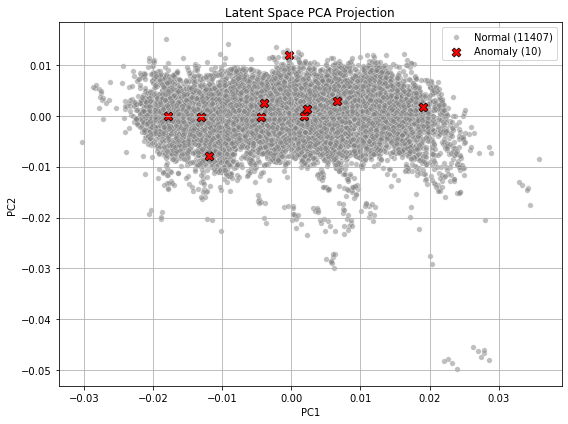

Normal samples: 11407
Anomaly samples: 10


In [192]:
import torch

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import pandas as pd
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

model.eval()
 
latent_vectors = []
 
with torch.no_grad():

    for batch in vae_vdl:

        batch = batch.to(device)

        z = model.encoder(batch)

        latent_vectors.append(z.cpu())
 
latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
 
# Ensure y_test is numpy array and aligned with latent vectors

if isinstance(y_test, torch.Tensor):

    y_test = y_test.cpu().numpy()
 
y_test_aligned = y_test[:latent_vectors.shape[0]]
 
# Map binary labels to strings for plotting

label_names = np.array(['Normal', 'Anomaly'])

y_labels = label_names[y_test_aligned]
 
# PCA projection

pca = PCA(n_components=2)

latent_pca = pca.fit_transform(latent_vectors)
 
# Prepare DataFrame for plotting

df = pd.DataFrame({

    'PC1': latent_pca[:, 0],

    'PC2': latent_pca[:, 1],

    'Label': y_labels

})
 
# Count samples per label

counts = df['Label'].value_counts().to_dict()

normal_label = f"Normal ({counts.get('Normal', 0)})"

anomaly_label = f"Anomaly ({counts.get('Anomaly', 0)})"
 
# Plot

plt.figure(figsize=(8,6))
 
# Normal points

sns.scatterplot(

    data=df[df['Label'] == 'Normal'],

    x='PC1', y='PC2',

    label=normal_label,

    color='gray',

    alpha=0.5,

    s=30

)
 
# Anomaly points

sns.scatterplot(

    data=df[df['Label'] == 'Anomaly'],

    x='PC1', y='PC2',

    label=anomaly_label,

    color='red',

    marker='X',

    s=80,

    edgecolor='black'

)
 
plt.title('Latent Space PCA Projection')

plt.grid(True)

plt.legend()

plt.tight_layout()
 
plt.savefig('autoencoder_latentspace_disa.png')  # You can specify the path if needed
 
 
plt.show()
 
# Optional: print counts

print(f"Normal samples: {counts.get('Normal', 0)}")

print(f"Anomaly samples: {counts.get('Anomaly', 0)}")

 

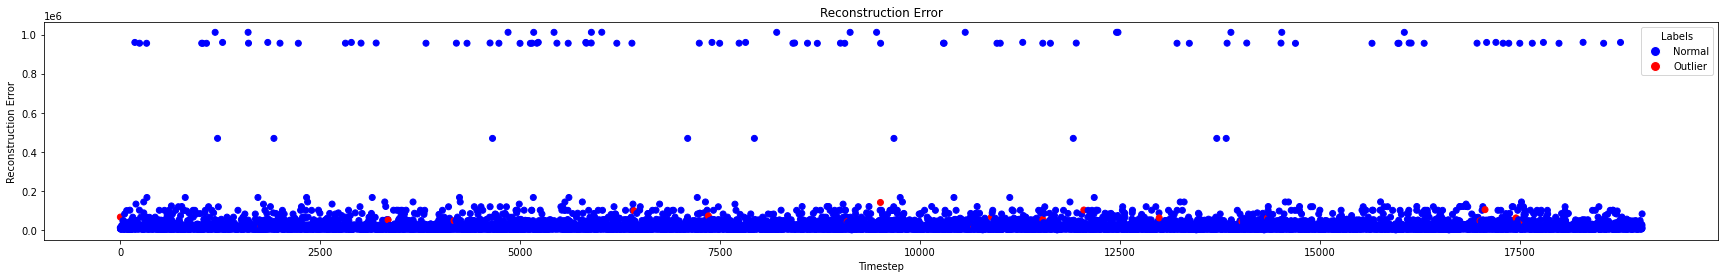

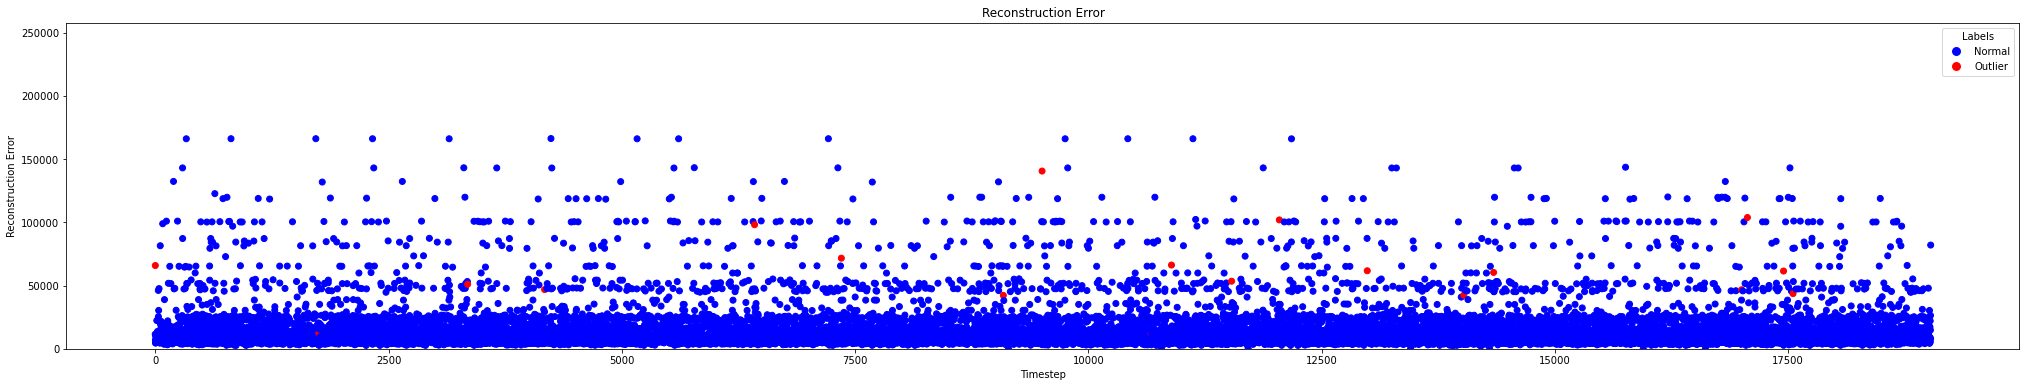

In [141]:
# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

reco_clean = reco[~np.isnan(reco)] # Reco has NaNs

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco_clean)*30)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

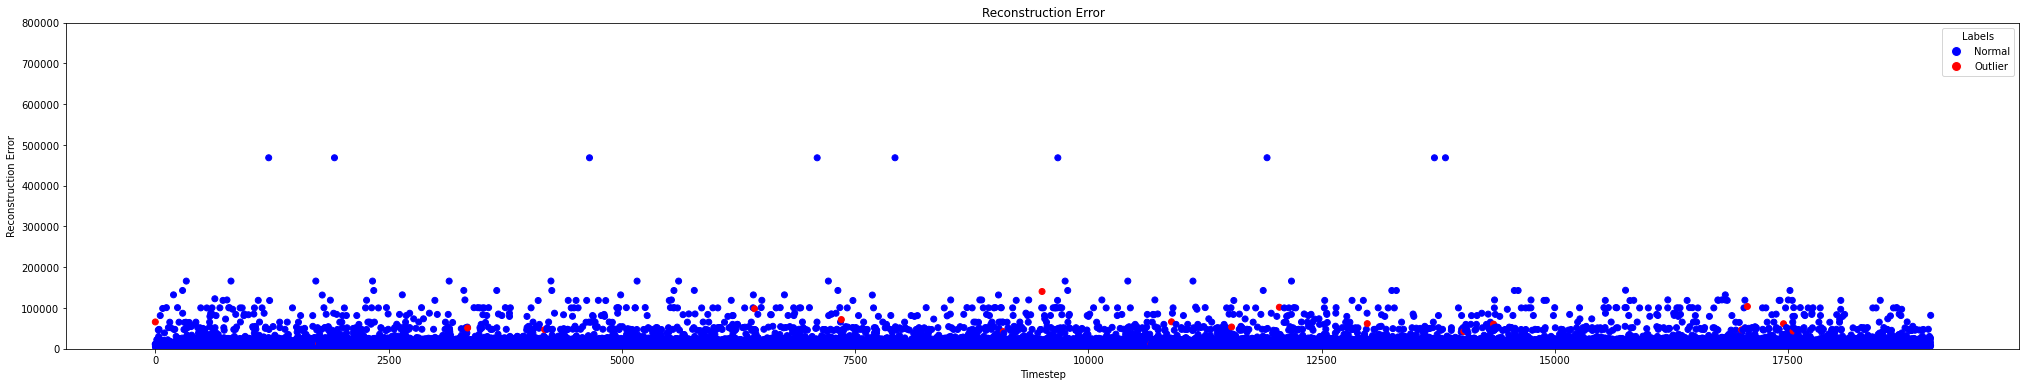

In [142]:
# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, 800000)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

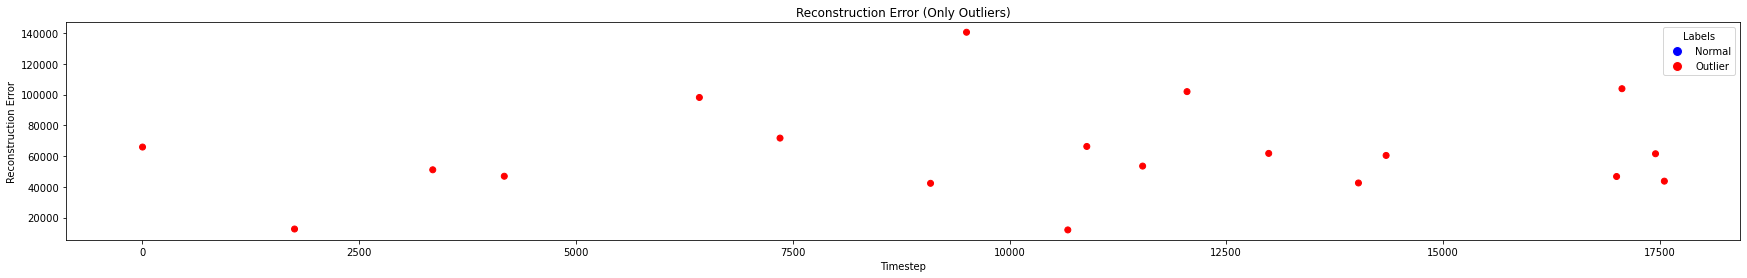

In [143]:
# Solo outliers (label == 1)
outlier_indices = y_test == 1

plt.figure(figsize=(30, 4))
plt.scatter(np.where(outlier_indices)[0], reco[outlier_indices], c=test_label_colors[outlier_indices],
            label='Reconstruction Error (Outliers)')
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error (Only Outliers)')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()


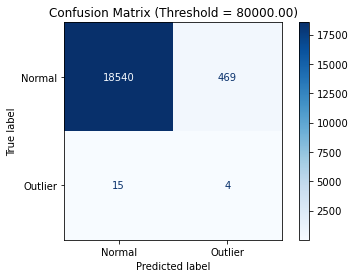

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Threshold
threshold = 80000

# Clasification
y_pred = (reco > threshold).astype(int)

# Labels
y_true = y_test.astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Outlier'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {threshold:.2f})')
plt.show()

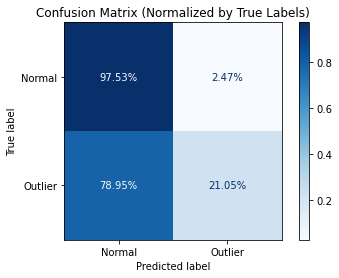

In [145]:
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Outlier'])
disp.plot(cmap='Blues', values_format='.2%')  # '.2%' para mostrar porcentaje con 2 decimales
plt.title('Confusion Matrix (Normalized by True Labels)')
plt.show()

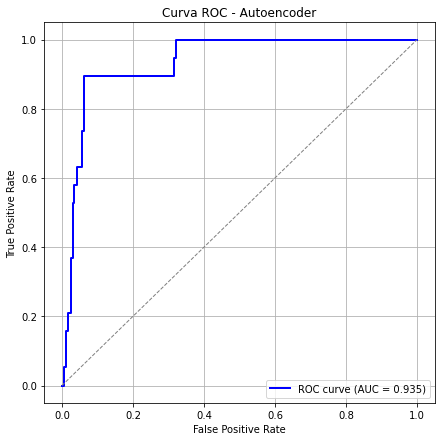

In [146]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, reco)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Autoencoder')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [147]:
thresholds

array([           inf, 1.01186480e+06, 1.42991181e+05, 1.40560459e+05,
       1.18342548e+05, 1.03822184e+05, 1.02292081e+05, 1.01929195e+05,
       9.89156316e+04, 9.81158770e+04, 7.28510346e+04, 6.62343068e+04,
       6.59120118e+04, 6.58496557e+04, 6.45542510e+04, 6.03887703e+04,
       5.34811377e+04, 5.34640089e+04, 5.11017396e+04, 5.10498355e+04,
       4.72150335e+04, 4.66807646e+04, 4.46685852e+04, 4.22488281e+04,
       1.25073083e+04, 1.25032185e+04, 1.19235998e+04, 1.19217700e+04,
       2.13355810e+00])

In [148]:
best_f1 = 0
best_thresh = 0
for thresh in thresholds:
    y_pred = (reco > thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f'Best threshold (F1): {best_thresh:.4f} with F1 = {best_f1:.4f}')

Best threshold (F1): 60388.7703 with F1 = 0.0291


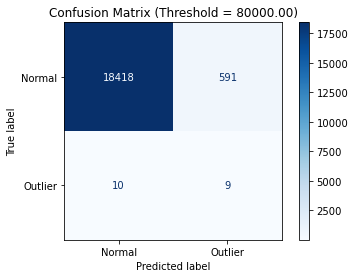

In [149]:
# Clasification
y_pred = (reco > best_thresh).astype(int)

# Labels
y_true = y_test.astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Outlier'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {threshold:.2f})')
plt.show()

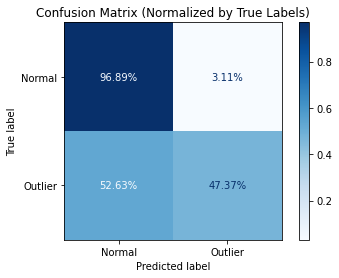

In [150]:
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Outlier'])
disp.plot(cmap='Blues', values_format='.2%')  # '.2%' para mostrar porcentaje con 2 decimales
plt.title('Confusion Matrix (Normalized by True Labels)')
plt.show()

In [151]:
model.reconstruction_losses

[]

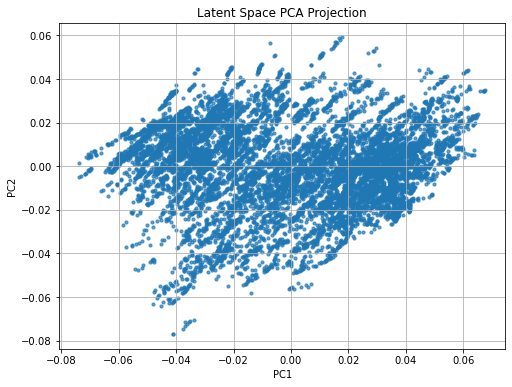

/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



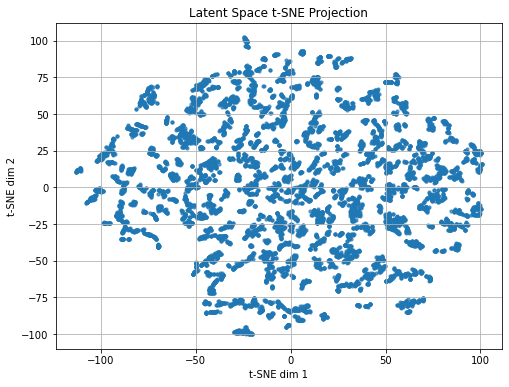

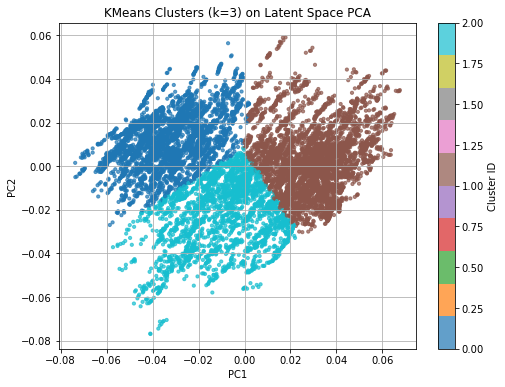

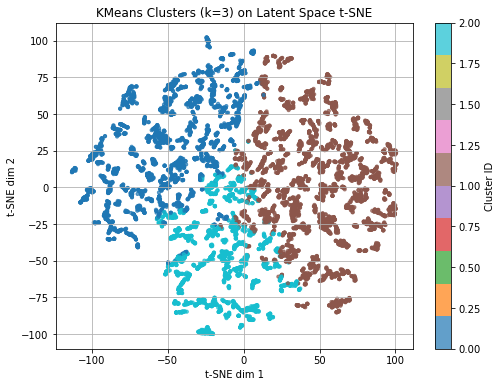

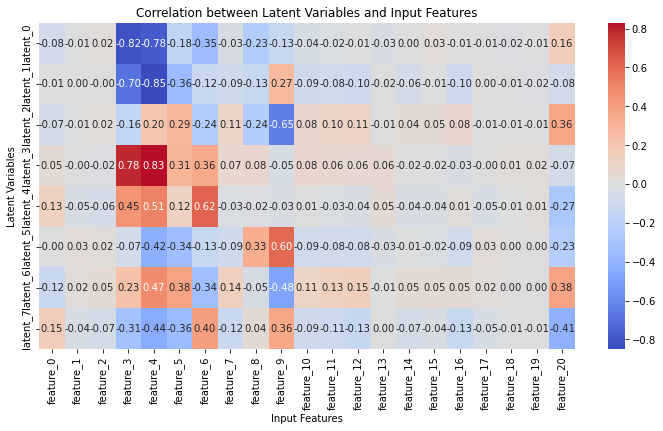

In [152]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
inputs = []

with torch.no_grad():
    for batch in vae_vdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        latent_vectors.append(z.cpu())
        inputs.append(batch.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
inputs = torch.cat(inputs, dim=0).numpy()

# --- PCA visualization ---
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s=10, alpha=0.7)
plt.title('Latent Space PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# --- t-SNE visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], s=10, alpha=0.7)
plt.title('Latent Space t-SNE Projection')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.grid(True)
plt.show()

# --- KMeans clustering (on original latent vectors) ---
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_vectors)

# Plot clusters on PCA
plt.figure(figsize=(8,6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clusters (k={n_clusters}) on Latent Space PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# Plot clusters on t-SNE
plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clusters (k={n_clusters}) on Latent Space t-SNE')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.grid(True)
plt.show()

# --- Correlation heatmap ---
latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
input_df = pd.DataFrame(inputs, columns=[f'feature_{i}' for i in range(inputs.shape[1])])

corr_matrix = pd.concat([latent_df, input_df], axis=1).corr()
corr_latent_features = corr_matrix.loc[latent_df.columns, input_df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_latent_features, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Latent Variables and Input Features")
plt.xlabel("Input Features")
plt.ylabel("Latent Variables")
plt.show()

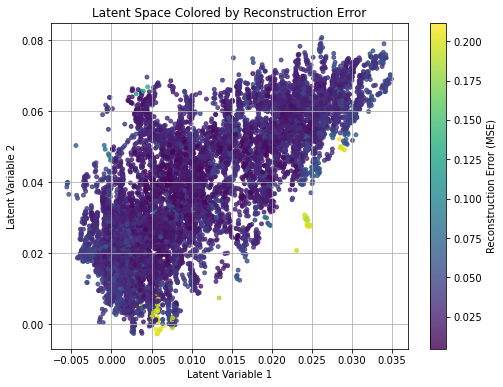

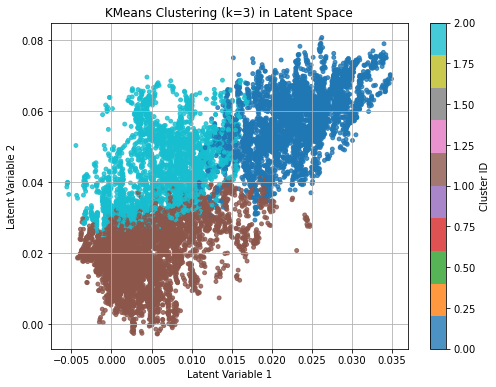

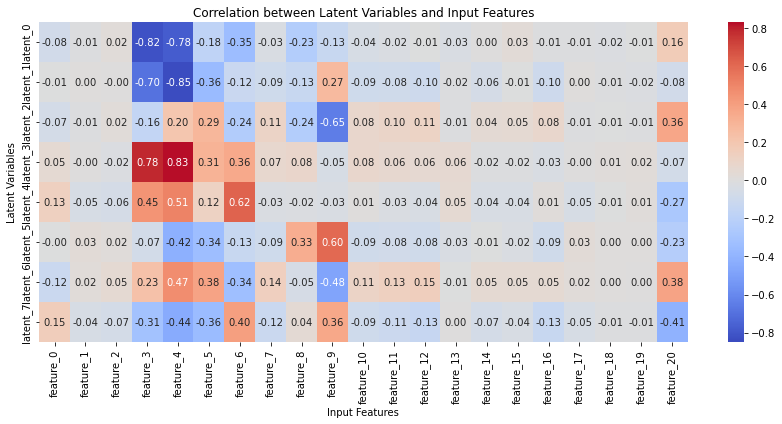

In [153]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import animation

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
inputs = []
recon_errors = []
time_steps = []  # Optional: fill if you have time info

# --- Inference Loop ---
with torch.no_grad():
    for i, batch in enumerate(vae_vdl):
        batch = batch.to(device)
        z = model.encoder(batch)
        recon = model.decoder(z)
        loss = torch.nn.functional.mse_loss(recon, batch, reduction='none')
        per_sample_mse = loss.view(loss.size(0), -1).mean(dim=1)

        latent_vectors.append(z.cpu())
        inputs.append(batch.cpu())
        recon_errors.append(per_sample_mse.cpu())
        time_steps.extend([i] * batch.size(0))  # Optional

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
inputs = torch.cat(inputs, dim=0).numpy()
recon_errors = torch.cat(recon_errors, dim=0).numpy()
time_steps = np.array(time_steps)  # Optional

# --- Scatter plot with reconstruction error ---
plt.figure(figsize=(8,6))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
                 c=recon_errors, cmap='viridis', s=15, alpha=0.8)
plt.colorbar(sc, label='Reconstruction Error (MSE)')
plt.title('Latent Space Colored by Reconstruction Error')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.grid(True)
plt.show()

# --- KMeans Clustering ---
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=clusters, cmap='tab10', s=15, alpha=0.8)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clustering (k={n_clusters}) in Latent Space')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.grid(True)
plt.show()

# --- Correlation Heatmap ---
latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
input_df = pd.DataFrame(inputs, columns=[f'feature_{i}' for i in range(inputs.shape[1])])

corr_matrix = pd.concat([latent_df, input_df], axis=1).corr()
corr_latent_features = corr_matrix.loc[latent_df.columns, input_df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_latent_features, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Latent Variables and Input Features")
plt.xlabel("Input Features")
plt.ylabel("Latent Variables")
plt.tight_layout()
plt.show()

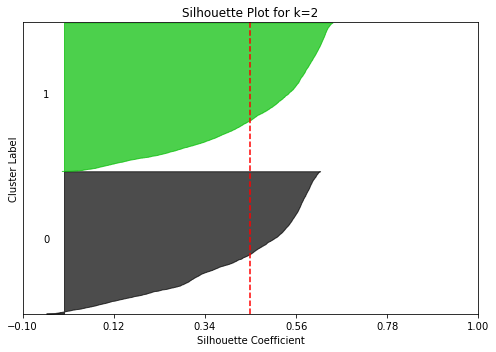

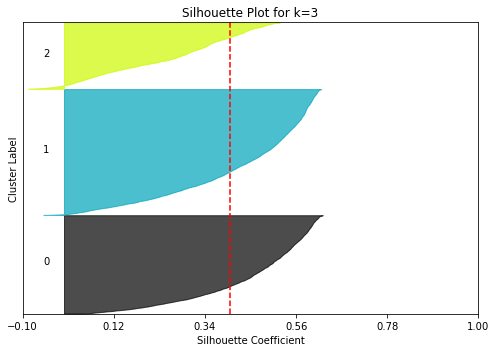

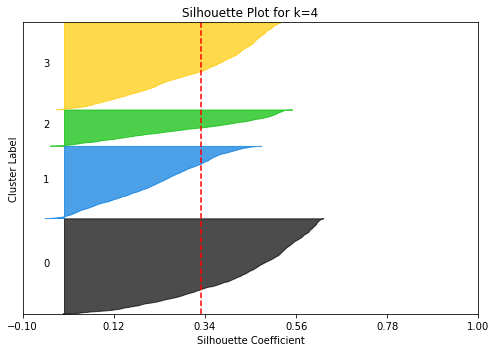

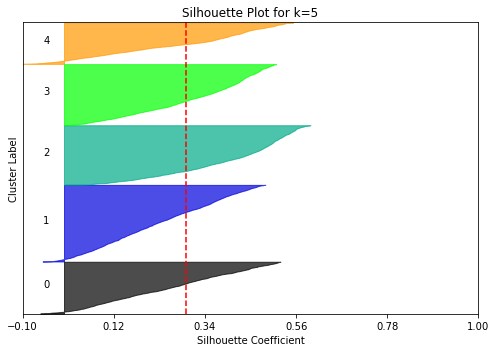

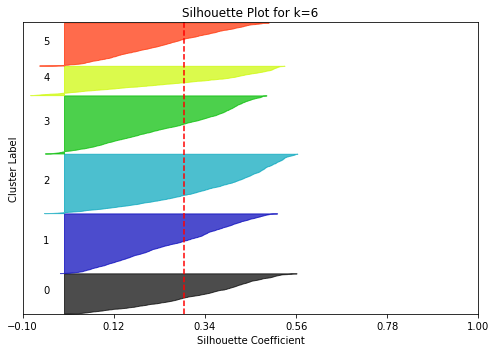

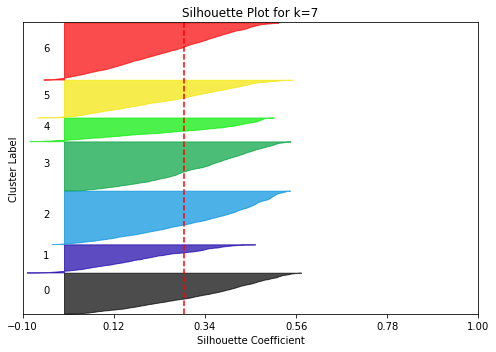

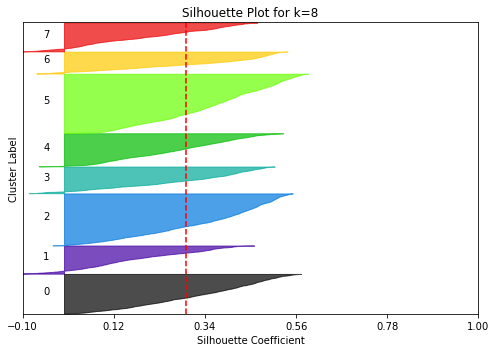

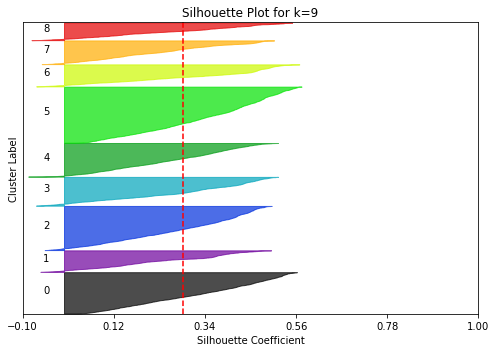

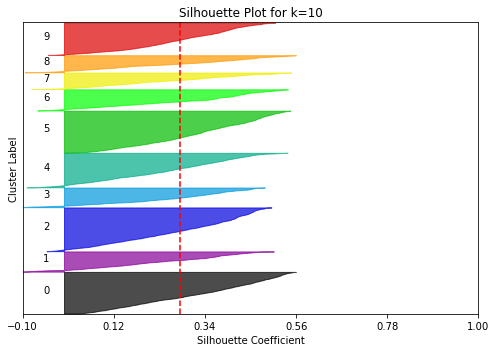

✅ Optimal number of clusters: 2 (Silhouette score: 0.449)


In [154]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Range of k values to try
k_range = range(2, 11)

best_k = None
best_score = -1
best_labels = None

for k in k_range:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(latent_vectors) + (k + 1) * 10])

    # Apply KMeans and compute silhouette scores
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    silhouette_avg = silhouette_score(latent_vectors, cluster_labels)
    sample_silhouette_values = silhouette_samples(latent_vectors, cluster_labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k
        best_labels = cluster_labels

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing

    ax1.set_title(f"Silhouette Plot for k={k}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.linspace(-0.1, 1.0, 6))
    plt.tight_layout()
    plt.show()

print(f"✅ Optimal number of clusters: {best_k} (Silhouette score: {best_score:.3f})")

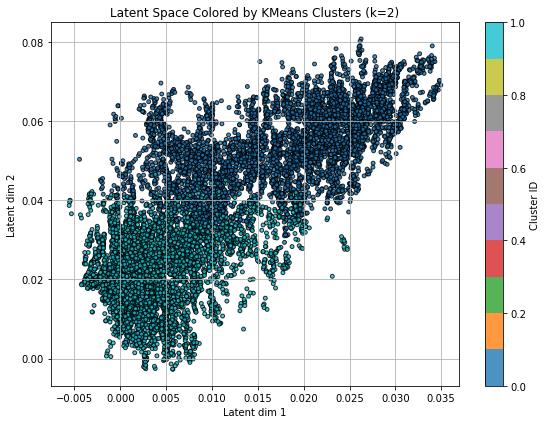

In [155]:
plt.figure(figsize=(8, 6))
plt.scatter(
    latent_vectors[:, 0],
    latent_vectors[:, 1],
    c=best_labels,
    cmap='tab10',
    s=15,
    alpha=0.8,
    edgecolor='k'
)
plt.title(f'Latent Space Colored by KMeans Clusters (k={best_k})')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()


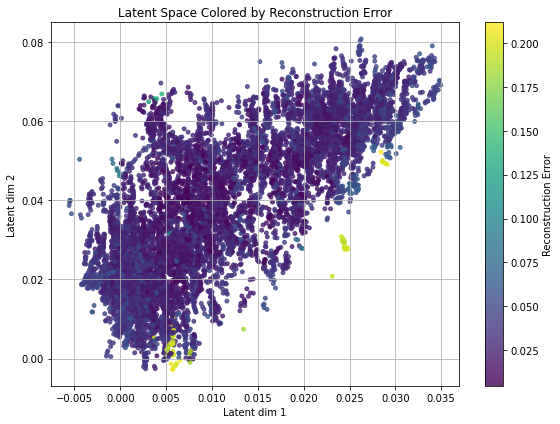

In [156]:
import torch.nn.functional as F

# Recompute reconstructions
with torch.no_grad():
    latent_tensor = torch.tensor(latent_vectors).to(device).float()
    reconstructions = model.decoder(latent_tensor).cpu()

# Compute reconstruction error (MSE per sample)
reconstruction_errors = F.mse_loss(torch.tensor(inputs), reconstructions, reduction='none')
reconstruction_errors = reconstruction_errors.mean(dim=1).numpy()

# Scatter plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    latent_vectors[:, 0],
    latent_vectors[:, 1],
    c=reconstruction_errors,
    cmap='viridis',
    s=15,
    alpha=0.8
)
plt.title('Latent Space Colored by Reconstruction Error')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.colorbar(sc, label='Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()



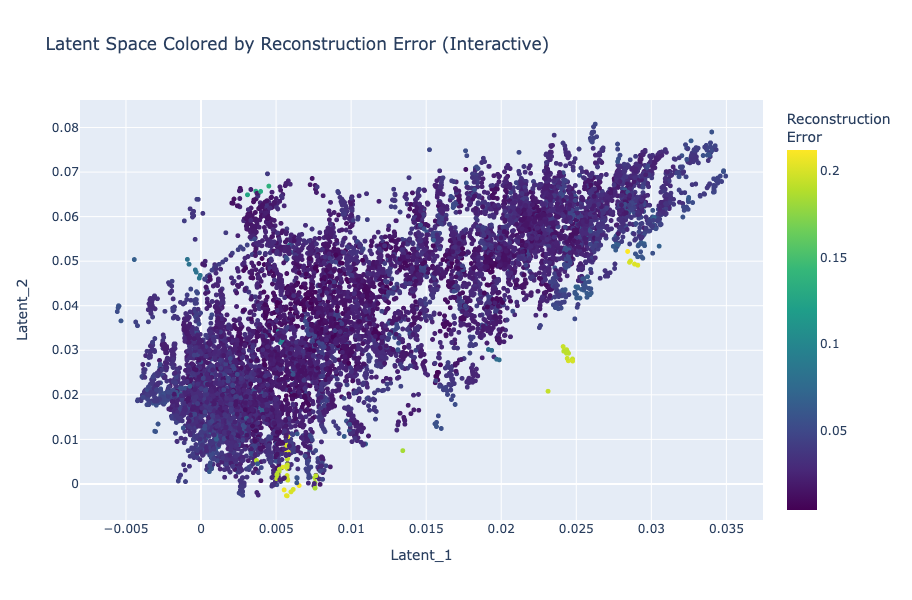

In [157]:
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    'Latent_1': latent_vectors[:, 0],
    'Latent_2': latent_vectors[:, 1],
    'Reconstruction_Error': reconstruction_errors
})

fig = px.scatter(
    df,
    x='Latent_1',
    y='Latent_2',
    color='Reconstruction_Error',
    color_continuous_scale='Viridis',
    title='Latent Space Colored by Reconstruction Error (Interactive)',
    hover_data=['Reconstruction_Error'],
    width=800,
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(coloraxis_colorbar=dict(title="Reconstruction<br>Error"))
fig.show()
